# Classifying multi-label comments with Logistic Regression
Izzy
Started on March 30

-- inspired by:

kernel by Jeremy Howard : NB-SVM strong linear baseline + EDA (0.052 lb)
kernel by Issac : logistic regression (0.055 lb)
Solving Multi-Label Classification problems, https://www.analyticsvidhya.com/blog/2017/08/introduction-to-multi-label-classification/

In [1]:
# importing libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import re

df = pd.read_csv('/Users/isabelmetzger/PycharmProjects/OA-STM-Corpus/fileCategories.txt','\t', header=None)
df_wanted_files = df[df[1].isin(['Medicine', 'Biology'])]
print(df[1].value_counts())
file_list = [x + '.txt' for x in df_wanted_files[0]]


Agriculture          11
Biology              11
Engineering          11
Medicine             11
Materials Science    11
Mathematics          11
Computer Science     11
Chemistry            11
Astronomy            11
Earth Science        11
Name: 1, dtype: int64


In [ ]:
mimic_notes = pd.read_csv('/Users/isabelmetzger/PycharmProjects/ConsumerDrugReviewMachineLearning/data/NOTEEVENTS.csv')
mimic_notes.head()

In [51]:
df = pd.read_csv('/Users/isabelmetzger/Documents/2018/n2c2/df_binary_n2c2.csv')
#X = df[['uniqueID', 'text_data']]
#y = df[['ABDOMINAL',
#       'ADVANCED.CAD', 'ALCOHOL.ABUSE', 'ASP.FOR.MI', 'CREATININE',
#       'DIETSUPP.2MOS', 'DRUG.ABUSE', 'ENGLISH', 'HBA1C', 'KETO.1YR',
#       'MAJOR.DIABETES', 'MAKES.DECISIONS', 'MI.6MOS']]
#X.rename(columns={'text_data': 'text','uniqueID': 'id'})
# y.head()
df.head()

,id,text,ABDOMINAL,ADVANCED.CAD,ALCOHOL.ABUSE,ASP.FOR.MI,CREATININE,DIETSUPP.2MOS,DRUG.ABUSE,ENGLISH,HBA1C,KETO.1YR,MAJOR.DIABETES,MAKES.DECISIONS,MI.6MOS
0,1,Record date: 2106-02-12 \n \nCampbell Orthoped...,0,1,0,1,0,1,0,1,0,0,1,1,1
1,2,Record date: 2079-05-12 \n \n \n \n \n \nMERCY...,0,1,0,1,0,0,0,1,0,0,0,1,0
2,3,Record date: 2120-09-19 \n \nPersonal Data and...,1,1,0,1,0,0,0,1,0,0,1,1,0
3,4,Record date: 2067-11-24 \n \n ...,0,1,0,1,0,0,0,1,0,0,0,1,0
4,5,Record date: 2094-02-16 \n \nJENNIFER BOOKER \...,0,1,0,0,0,0,0,1,1,0,1,1,1


In [19]:
import glob
import os
list_json_dosing_guidelines = glob.glob("/Users/isabelmetzger/MAE/dosingGuidelines.json/*.json")
import ujson

def read_dosing_guidelines(inpath):#, outpath):
    with open(inpath) as f:
        uj = ujson.load(f)
        for k, v in uj.items():
            print(k, v)
        #print(uj['guideline']['name'])
read_dosing_guidelines(list_json_dosing_guidelines[0])

guideline {'@id': 'https://pharmgkb.org/guideline/PA166105003', '@context': 'https://api.pharmgkb.org/jsonld/guideline.jsonld', 'objCls': 'Guideline', 'id': 'PA166105003', 'name': 'Annotation of CPIC Guideline for allopurinol and HLA-B', 'descriptiveVideoId': 'qbDsCEYbo4k', 'guidelineGenes': [], 'history': [{'id': 1183699762, 'date': '2012-10-17T00:00:00-07:00', 'type': 'create', 'version': 0}, {'id': 1444841843, 'date': '2015-06-11T15:10:54.200-07:00', 'description': 'Published update', 'type': 'update', 'version': 0}, {'id': 1444841850, 'date': '2015-06-12T08:50:16.155-07:00', 'type': 'update', 'version': 0}], 'recommendation': True, 'relatedChemicals': [{'@id': 'https://pharmgkb.org/chemical/PA448320', '@context': 'https://api.pharmgkb.org/jsonld/chemical.jsonld', 'objCls': 'Chemical', 'id': 'PA448320', 'name': 'allopurinol', 'version': 5}], 'relatedGenes': [{'@id': 'https://pharmgkb.org/gene/PA35056', '@context': 'https://api.pharmgkb.org/jsonld/gene.jsonld', 'objCls': 'Gene', 'id'

In [9]:
example = '/Users/isabelmetzger/MAE/dosingGuidelines.json/Annotation_of_PRO_Guideline_for_irinotecan_and_UGT1A1.json'
with open(example) as f:
    ujson.load(f)

In [54]:
train_df.describe()

,id,ABDOMINAL,ADVANCED.CAD,ALCOHOL.ABUSE,ASP.FOR.MI,CREATININE,DIETSUPP.2MOS,DRUG.ABUSE,ENGLISH,HBA1C,KETO.1YR,MAJOR.DIABETES,MAKES.DECISIONS,MI.6MOS
count,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000,138.000000
mean,94.333333,0.376812,0.673913,0.036232,0.789855,0.391304,0.536232,0.065217,0.963768,0.333333,0.007246,0.543478,0.956522,0.108696
std,58.955177,0.486352,0.470487,0.187547,0.408896,0.489820,0.500502,0.247809,0.187547,0.473122,0.085126,0.499921,0.204674,0.312391
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,44.250000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,83.500000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000
75%,141.750000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000
max,202.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [30]:
cols_target =['ABDOMINAL',
       'ADVANCED.CAD', 'ALCOHOL.ABUSE', 'ASP.FOR.MI', 'CREATININE',
       'DIETSUPP.2MOS', 'DRUG.ABUSE', 'ENGLISH', 'HBA1C', 'KETO.1YR',
       'MAJOR.DIABETES', 'MAKES.DECISIONS', 'MI.6MOS']
print('Total rows in test is {}'.format(len(test_df)))
print('Total rows in train is {}'.format(len(train_df)))
print(train_df[cols_target].sum())

Total rows in test is 70
Total rows in train is 132
ABDOMINAL           55
ADVANCED.CAD        81
ALCOHOL.ABUSE        4
ASP.FOR.MI         104
CREATININE          53
DIETSUPP.2MOS       66
DRUG.ABUSE          10
ENGLISH            127
HBA1C               43
KETO.1YR             1
MAJOR.DIABETES      74
MAKES.DECISIONS    129
MI.6MOS             11
dtype: int64


In [55]:
no_comment = train_df[train_df['text'].isnull()]
len(no_comment)  # no missings

0

/Users/isabelmetzger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


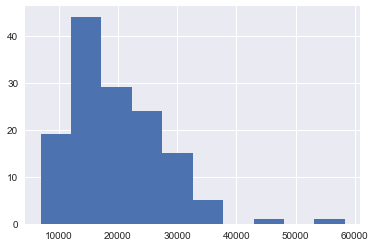

In [56]:
train_df['char_length'] = train_df['text'].apply(lambda x: len(str(x)))
# look at the histogram plot for text length
sns.set()
train_df['char_length'].hist()
plt.show()

In [57]:
data = train_df[cols_target]

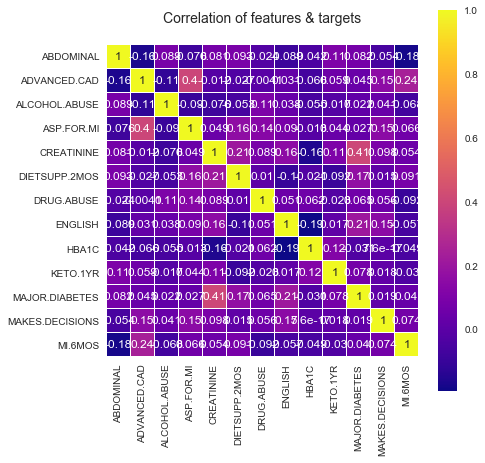

In [58]:
colormap = plt.cm.plasma
plt.figure(figsize=(7,7))
plt.title('Correlation of features & targets',y=1.05,size=14)
sns.heatmap(data.astype(float).corr(),linewidths=0.1,vmax=1.0,square=True,cmap=colormap,
           linecolor='white',annot=True)

/Users/isabelmetzger/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


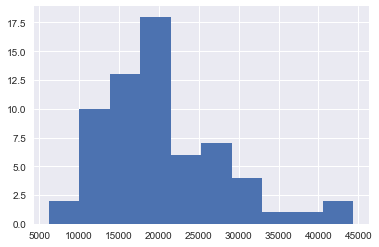

In [59]:
test_df['char_length'] = test_df['text'].apply(lambda x: len(str(x)))
plt.figure()
plt.hist(test_df['char_length'])
plt.show()

In [38]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [60]:
X = train_df.text
test_X = test_df.text
print(X.shape, test_X.shape)

(138,) (64,)


In [61]:
# import and instantiate TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vect = TfidfVectorizer(max_features=5000,stop_words='english')
vect

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [62]:
# learn the vocabulary in the training data, then use it to create a document-term matrix
X_dtm = vect.fit_transform(X)
# examine the document-term matrix created from X_train
X_dtm

<138x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 101671 stored elements in Compressed Sparse Row format>

In [63]:
# transform the test data using the earlier fitted vocabulary, into a document-term matrix
test_X_dtm = vect.transform(test_X)
# examine the document-term matrix from X_test
test_X_dtm

<64x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 47338 stored elements in Compressed Sparse Row format>

# Solving a multi-label classification problem
One way to approach a multi-label classification problem is to transform the problem into separate single-class classifier problems. This is known as 'problem transformation'. There are three methods:

Binary Relevance. This is probably the simplest which treats each label as a separate single classification problems. The key assumption here though, is that there are no correlation among the various labels.


Classifier Chains. In this method, the first classifier is trained on the input X. Then the subsequent classifiers are trained on the input X and all previous classifiers' predictions in the chain. This method attempts to draw the signals from the correlation among preceding target variables.


Label Powerset. This method transforms the problem into a multi-class problem where the multi-class labels are essentially all the unique label combinations. In our case here, where there are six labels, Label Powerset would in effect turn this into a 2^6 or 64-class problem. {Thanks Joshua for pointing out.}


# tfidf

In [64]:
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_dtm, train_df.text, train_size=0.75)

In [69]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import f1_score

model_tfidf_NB = MultinomialNB()
for label in cols_target:
    print('Processing {}'.format(label))
    y = train_df[label]
    model_tfidf_NB.fit(X_dtm, y)
    y_pred_X = model_tfidf_NB.predict(X_dtm)
    print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
    print('Training f1 macro is {}'.format(f1_score(y, y_pred_X, average='macro')))  
    print('Training f1 micro is {}'.format(f1_score(y, y_pred_X, average='micro')))  
    print('Training f1 weighted is {}'.format(f1_score(y, y_pred_X, average='weighted')))  
    test_y_prob = model_tfidf_NB.predict_proba(test_X_dtm)[:,1]

Processing ABDOMINAL
Training accuracy is 0.6594202898550725
Training f1 macro is 0.4804133621725547
Training f1 micro is 0.6594202898550725
Training f1 weighted is 0.5555520725578091
Processing ADVANCED.CAD
Training accuracy is 0.6739130434782609
Training f1 macro is 0.4025974025974026
Training f1 micro is 0.6739130434782609
Training f1 weighted is 0.5426312817617166
Processing ALCOHOL.ABUSE
Training accuracy is 0.9637681159420289
Training f1 macro is 0.4907749077490775
Training f1 micro is 0.9637681159420289
Training f1 weighted is 0.945986416385903
Processing ASP.FOR.MI
Training accuracy is 0.7898550724637681
Training f1 macro is 0.44129554655870445
Training f1 micro is 0.7898550724637681
Training f1 weighted is 0.6971190518101273
Processing CREATININE
Training accuracy is 0.644927536231884
Training f1 macro is 0.4718425369054128
Training f1 micro is 0.644927536231884
Training f1 weighted is 0.5375710176623006
Processing DIETSUPP.2MOS
Training accuracy is 0.8840579710144928
Training

/Users/isabelmetzger/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [74]:
cols_target
X_train_tfidf

<103x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 75915 stored elements in Compressed Sparse Row format>

In [78]:
# using binary relevance
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = BinaryRelevance(GaussianNB())
#for label in cols_target:
#    print('Processing {}'.format(label))
#    y = train_df[label]
#    classifier.fit(X_dtm, y)
#    y_pred_X = classifier.predict(X_dtm)
#    print('Training accuracy is {}'.format(accuracy_score(y, y_pred_X)))
#    print('Training f1 macro is {}'.format(f1_score(y, y_pred_X, average='macro')))  
#    print('Training f1 micro is {}'.format(f1_score(y, y_pred_X, average='micro')))  
#    print('Training f1 weighted is {}'.format(f1_score(y, y_pred_X, average='weighted')))  
#    test_y_prob = classifier.predict_proba(test_X_dtm)[:,1]
classifier = BinaryRelevance(GaussianNB())

# train
classifier.fit(X_train_tfidf, y_train_tfidf)

# predict
predictions = classifier.predict(X_test_tfidf)

from sklearn.metrics import accuracy_score
accuracy_score(y_test_tfidf,predictions)
from sklearn.metrics import f1_score
f1_score(y_test_tfidf, predictions)

TypeError: no supported conversion for types: (dtype('O'),)

In [77]:
from sklearn.datasets import make_multilabel_classification
X, y = make_multilabel_classification(sparse = True, n_labels = 20,
return_indicator = 'sparse', allow_unlabeled = False)
X

<100x20 sparse matrix of type '<class 'numpy.float64'>'
	with 1793 stored elements in Compressed Sparse Row format>

In [41]:
firstimported_df = pd.read_csv('https://raw.githubusercontent.com/izzykayu/n2c2/master/train/dataframe_new_all.csv?token=AckLJKImUeG22nTpk4_xbfazkhEuZPMuks5axvyDwA%3D%3D')
firstimported_df.head(2)

,Unnamed: 0,text_data,uniqueID,.id,ABDOMINAL,ADVANCED.CAD,ALCOHOL.ABUSE,ASP.FOR.MI,CREATININE,DIETSUPP.2MOS,DRUG.ABUSE,ENGLISH,HBA1C,KETO.1YR,MAJOR.DIABETES,MAKES.DECISIONS,MI.6MOS,UNIQUENUMBER
0,1,Record date: 2106-02-12 \n \nCampbell Orthoped...,1,TAGS,not met,met,not met,met,not met,met,not met,met,not met,not met,met,met,met,1
1,2,Record date: 2079-05-12 \n \n \n \n \n \nMERCY...,2,TAGS,not met,met,not met,met,not met,not met,not met,met,not met,not met,not met,met,not met,2


In [52]:
import sys
from astropy.table import Table
from skmultilearn.adapt import MLkNN
lens = train.comment_text.str.len()
lens.mean(), lens.std(), lens.max()


AttributeError: 'DataFrame' object has no attribute 'comment_text'

In [48]:

from sklearn.model_selection import StratifiedKFold
from skmultilearn.problem_transform import LabelPowerset

lp = LabelPowerset()

n_splits = 2
kf = StratifiedKFold(n_splits=n_splits, random_state=None)

for train_index, test_index in kf.split(X, lp.transform(y)):

    # assuming classifier object exists
    X_train = X[train_index,:]
    y_train = y[train_index,:]

    X_test = X[test_index,:]
    y_test = y[test_index,:]

/Users/isabelmetzger/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=2.
  % (min_groups, self.n_splits)), Warning)


TypeError: unhashable type: 'numpy.ndarray'

In [ ]:
import pandas as pd, numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
